In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
!pip install opencv-python --user

In [72]:
def EncoderLayer():
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2
    return [
        keras.layers.Conv2D(filter_size, kernel_size = (kernel, kernel), padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation = 'relu'),
        keras.layers.Conv2D(filter_size, kernel_size = (kernel, kernel), padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation = 'relu'),
        keras.layers.MaxPooling2D(pool_size=(pool_size, pool_size)),

        keras.layers.Conv2D(128, kernel_size = (kernel, kernel), padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation ='relu'),
        keras.layers.Conv2D(128, kernel_size = (kernel, kernel), padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation ='relu'),
        keras.layers.MaxPooling2D(pool_size=(pool_size, pool_size)),

        keras.layers.Conv2D(256, kernel_size = (kernel, kernel), padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation = 'relu'),
        keras.layers.Conv2D(256, kernel_size = (kernel, kernel), padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation = 'relu'),
        keras.layers.Conv2D(256, kernel_size = (kernel, kernel), padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation = 'relu'),
        keras.layers.MaxPooling2D(pool_size=(pool_size, pool_size)),

        keras.layers.Conv2D(512, kernel_size = (kernel, kernel), padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation = 'relu'),
        keras.layers.Conv2D(512, kernel_size = (kernel, kernel), padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation = 'relu'),
        keras.layers.Conv2D(512, kernel_size = (kernel, kernel), padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation = 'relu'),
        keras.layers.MaxPooling2D(pool_size=(pool_size, pool_size)),]

In [73]:
def DecoderLayer():
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2
    return [keras.layers.UpSampling2D(size = (pool_size,pool_size)),
            keras.layers.Conv2D(512, kernel_size = (kernel, kernel), padding = 'same'),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(512, kernel_size = (kernel, kernel), padding = 'same'),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(512, kernel_size = (kernel, kernel), padding = 'same'),
            keras.layers.BatchNormalization(),
            
            keras.layers.UpSampling2D(size = (pool_size,pool_size)),
            keras.layers.Conv2D(256, kernel_size = (kernel, kernel), padding = 'same'),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(256, kernel_size = (kernel, kernel), padding = 'same'),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(256, kernel_size = (kernel, kernel), padding = 'same'),
            keras.layers.BatchNormalization(),

            keras.layers.UpSampling2D(size = (pool_size,pool_size)),
            keras.layers.Conv2D(128, kernel_size = (kernel, kernel), padding = 'same'),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(128, kernel_size = (kernel, kernel), padding = 'same'),
            keras.layers.BatchNormalization(),
            
            keras.layers.UpSampling2D(size = (pool_size,pool_size)),
            keras.layers.Conv2D(filter_size, kernel_size = (kernel, kernel), padding = 'same'),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filter_size, kernel_size = (kernel, kernel), padding = 'same'),
            keras.layers.BatchNormalization(),]

In [74]:
## Model with original data
model = tf.keras.Sequential()
model.add(tf.keras.layers.Layer(input_shape=(256, 256,3)))
model.encoding_layers = EncoderLayer()
model.decoding_layers = DecoderLayer()
for layer in model.encoding_layers:
    model.add(layer)
for layer in model.decoding_layers:
    model.add(layer)
model.add(keras.layers.Conv2D(3,1,1, padding = 'same'))
model.add(keras.layers.Activation(activation = 'softmax'))

In [75]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Layer)              (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization_20 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
activation_11 (Activation)   (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_21 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
activation_12 (Activation)   (None, 256, 256, 64)     

In [7]:
def dataset_setup(data_dir='', n_ims=2975, offset_bias=0, img_dim=256):
    """
    Method to import the training data from CityScape and divide into image-label pairs

    Inputs
    --
    data_dir: string
        Location for the data that is being imported
    n_ims: int
        Number of images contained in the folder chosen
    offset_bias: int
        Optionally, skip some images by starting at a position further than 0
    img_dim: int
        Expected image dimension (assuming square images)

    Outputs
    --
    X: list
        Images
    y: list
        Image labels per pixel
    """

    flist = os.listdir(data_dir)
    img0 = cv2.imread(data_dir+flist[0])

    y_dim,x_dim,_ = np.shape(img0)
    X = np.zeros((n_ims,y_dim,int(x_dim/2),3))
    y = np.zeros((n_ims,y_dim,int(x_dim/2),3))
    
    k = 0
    for f in flist[offset_bias:offset_bias+n_ims]:
        X[k] = cv2.imread(data_dir+f)[:,:img_dim]/img_dim
        y[k] = cv2.imread(data_dir+f)[:,img_dim:]/img_dim
        
        k = k+1

    return X, y

In [8]:
# Directories containing the train and val data
train_files = "./data/cityscapes_data/train/"
val_files = "./data/cityscapes_data/val/"

# Setup image-label pairs
x_train, y_train = dataset_setup(data_dir=train_files, n_ims=2975, offset_bias=0, img_dim=256)
x_val, y_val = dataset_setup(data_dir=val_files, n_ims=500, offset_bias=0, img_dim=256)

In [9]:
x_train1 = x_train[:20]
y_train1 = y_train[:20]

In [10]:
from sklearn.cluster import KMeans
colors = []
for i in range(len(x_train1)//2):
    colors.append(y_train1[i].reshape(y_train1[i].shape[0]*y_train1[i].shape[1], 3))
colors = np.array(colors)
colors = colors.reshape((colors.shape[0]*colors.shape[1],3))

km = KMeans(13)
km.fit(colors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=13, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [11]:
def ColorsToClass(seg):
    s = seg.reshape((seg.shape[0]*seg.shape[1],3))
    s = km.predict(s)
    s = s.reshape((seg.shape[0], seg.shape[1]))
    
    n = len(km.cluster_centers_)
    
    cls = np.zeros((seg.shape[0], seg.shape[1], n))
    
    for i in range(n):
        m = np.copy(s)
        m[m!=i] = 0
        m[m!=0] = 1
        
        cls[:,:,i]=m
        
    return cls

In [12]:
x_train1 = x_train[:500]
y_train1 = y_train[:500]

In [13]:
labels = []
for i in range(500):
    labels.append(ColorsToClass(y_train[i]))
labels = np.array(labels)

In [14]:
val_labels = []
for i in range(200):
    val_labels.append(ColorsToClass(y_val[i]))
val_labels = np.array(val_labels)

In [76]:
nb_epoch = 100
batch_size = 1
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [77]:
# trained model with original data shape (256,256,3)
history = model.fit(x_train[:500], y_train[:500], batch_size=batch_size, epochs=nb_epoch,verbose=1,validation_data = (x_val[:200],y_val[:200]))

Train on 500 samples, validate on 200 samples
Epoch 1/100
500/500 [==============================] - 28s 55ms/sample - loss: 1.1269 - accuracy: 0.4234 - val_loss: 1.1041 - val_accuracy: 0.3880
Epoch 2/100
500/500 [==============================] - 25s 50ms/sample - loss: 1.1128 - accuracy: 0.4871 - val_loss: 1.0952 - val_accuracy: 0.3111
Epoch 3/100
500/500 [==============================] - 25s 50ms/sample - loss: 1.1100 - accuracy: 0.4922 - val_loss: 1.1098 - val_accuracy: 0.4371
Epoch 4/100
500/500 [==============================] - 25s 50ms/sample - loss: 1.1067 - accuracy: 0.5077 - val_loss: 1.0875 - val_accuracy: 0.4432
Epoch 5/100
500/500 [==============================] - 25s 50ms/sample - loss: 1.1042 - accuracy: 0.5133 - val_loss: 1.0940 - val_accuracy: 0.3793
Epoch 6/100
500/500 [==============================] - 25s 50ms/sample - loss: 1.1017 - accuracy: 0.5210 - val_loss: 1.0834 - val_accuracy: 0.4141
Epoch 7/100
500/500 [==============================] - 25s 50ms/sample -

In [18]:
def LayersToRGBImage(img):
    colors = [(255,0,0), (0,255,0), (0,0,255),
             (255,255,0), (255,0,255), (0,255,255),
             (255,255,255), (200,50,0),(50,200,0),
             (50,0,200), (200,200,50), (0,50,200),
             (0,200,50), (0,0,0)]
    
    nimg = np.zeros((img.shape[0], img.shape[1], 3))
    for i in range(img.shape[2]):
        c = img[:,:,i]
        col = colors[i]
        
        for j in range(3):
            nimg[:,:,j]+=col[j]*c
    nimg = nimg/255.0
    return nimg

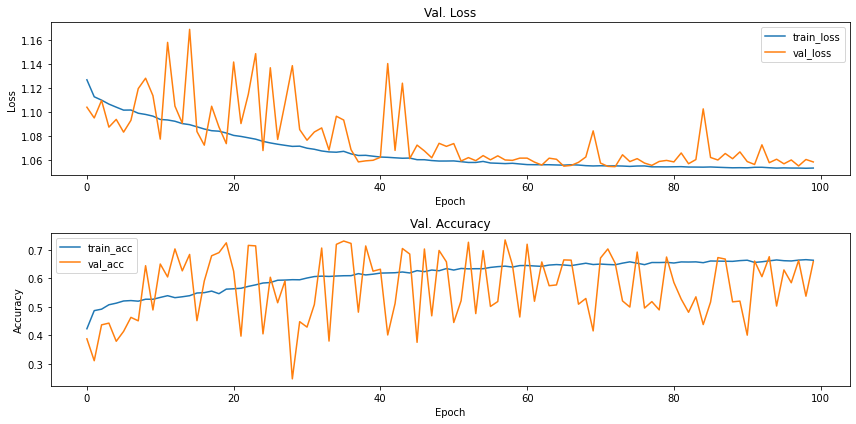

In [99]:
#original data loss plot
loss = history.history["loss"]
acc = history.history["accuracy"]
val_loss = history.history["val_loss"]
val_acc = history.history["val_accuracy"]

plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.title("Val. Loss")
plt.plot(loss,label = "train_loss")
plt.plot(val_loss,label = "val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')

plt.subplot(212)
plt.title("Val. Accuracy")
plt.plot(acc,label = "train_acc")
plt.plot(val_acc,label = "val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')

plt.tight_layout()
plt.savefig("learn.png", dpi=150)
plt.show()

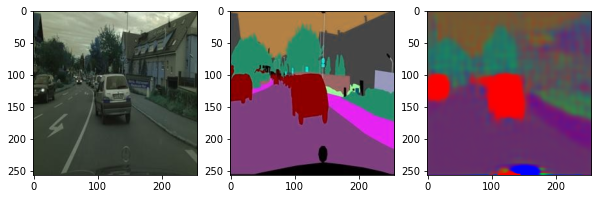

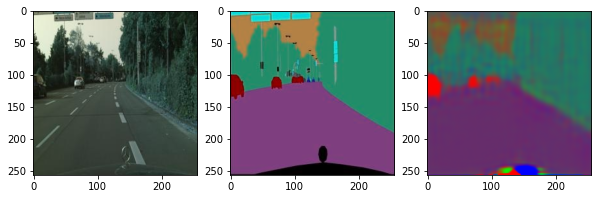

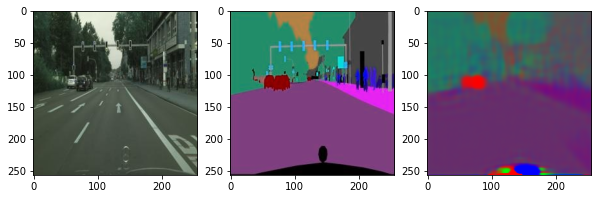

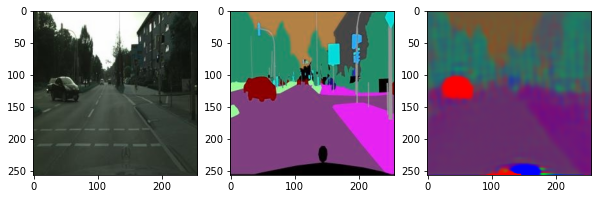

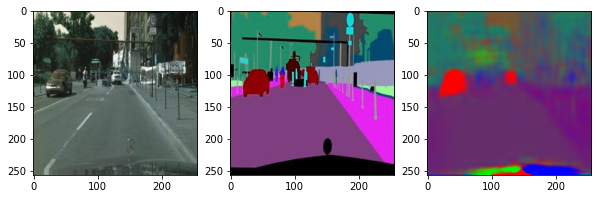

In [79]:
#model_1 output visualization
pp = model.predict(x_val[0:5,:,:,:])
ni = 5
for k in range(ni):
    pred = LayersToRGBImage(pp[k])
    plt.figure(figsize=(10,30))
    plt.subplot(ni,3,1+k*3)
    plt.imshow(x_val[k])
    plt.subplot(ni,3,2+k*3)
    plt.imshow(y_val[k])
    plt.subplot(ni,3,3+k*3)
    plt.imshow(pred)

In [81]:
# IoU score calculation
scores = []
a = []
b = []
pp = model.predict(x_val)
for i in range(len(pp)):
    a.append(pp[i])
    b.append(y_val[i])
    intersection = np.logical_and(b[i], a[i])
    union = np.logical_or(b[i], a[i])
    iou_score = np.sum(intersection) / np.sum(union)
    scores.append(iou_score)

In [82]:
#average IoU score
sum(scores)/len(scores)

0.9197844575040706

In [83]:
Manhattan =[]
for i in range(len(pp)):
    diff2 = y_val[i] - pp[i] 
    m_norm2 = np.sum(abs(diff2))  
    Manhattan.append(m_norm2/(256*256))

In [86]:
#average Manhattan distance
sum(Manhattan)/len(Manhattan)

0.39820518887581613

In [87]:
## Model with processed data with 13 channels
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Layer(input_shape=(256, 256,3)))
model2.encoding_layers = EncoderLayer()
model2.decoding_layers = DecoderLayer()
for layer in model2.encoding_layers:
    model2.add(layer)
for layer in model2.decoding_layers:
    model2.add(layer)
model2.add(keras.layers.Conv2D(13,1,1, padding = 'same'))
model2.add(keras.layers.Activation(activation = 'softmax'))

In [89]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_2 (Layer)              (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization_40 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
activation_22 (Activation)   (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_41 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
activation_23 (Activation)   (None, 256, 256, 64)     

In [90]:
nb_epoch = 100
batch_size = 1
model2.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [92]:
# trained model with processed data shape (256,256,13)
history2 = model2.fit(x_train[:500], labels[:500], batch_size=batch_size, epochs=nb_epoch,verbose=1,validation_data = (x_val[:200],val_labels[:200]))

Train on 500 samples, validate on 200 samples
Epoch 1/100
500/500 [==============================] - 30s 60ms/sample - loss: 1.0056 - accuracy: 0.4976 - val_loss: 1.9017 - val_accuracy: 0.4359
Epoch 2/100
500/500 [==============================] - 27s 54ms/sample - loss: 0.8686 - accuracy: 0.5242 - val_loss: 0.9789 - val_accuracy: 0.5296
Epoch 3/100
500/500 [==============================] - 27s 54ms/sample - loss: 0.8111 - accuracy: 0.5398 - val_loss: 1.3697 - val_accuracy: 0.3203
Epoch 4/100
500/500 [==============================] - 27s 54ms/sample - loss: 0.7758 - accuracy: 0.5525 - val_loss: 0.9722 - val_accuracy: 0.5419
Epoch 5/100
500/500 [==============================] - 27s 54ms/sample - loss: 0.7420 - accuracy: 0.5650 - val_loss: 0.9606 - val_accuracy: 0.5042
Epoch 6/100
500/500 [==============================] - 27s 54ms/sample - loss: 0.7210 - accuracy: 0.5725 - val_loss: 0.8803 - val_accuracy: 0.5770
Epoch 7/100
500/500 [==============================] - 27s 55ms/sample -

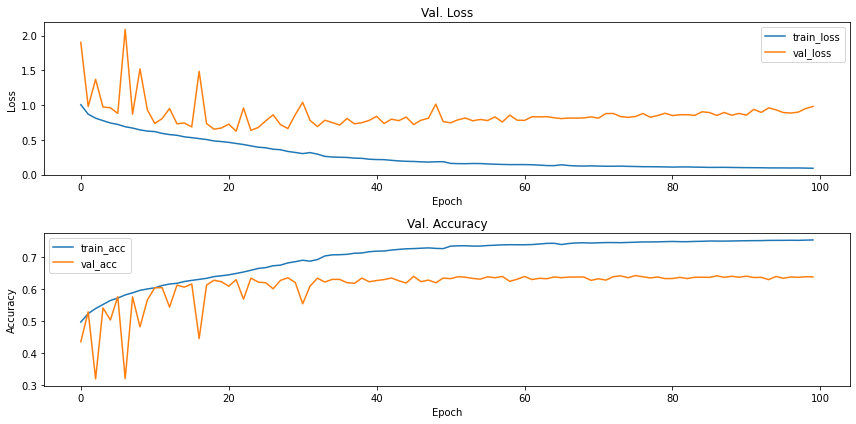

In [100]:
#processed data loss plot
loss = history2.history["loss"]
acc = history2.history["accuracy"]
val_loss = history2.history["val_loss"]
val_acc = history2.history["val_accuracy"]

plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.title("Val. Loss")
plt.plot(loss,label = "train_loss")
plt.plot(val_loss,label = "val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')

plt.subplot(212)
plt.title("Val. Accuracy")
plt.plot(acc,label = "train_acc")
plt.plot(val_acc,label = "val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')

plt.tight_layout()
plt.savefig("learn.png", dpi=150)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


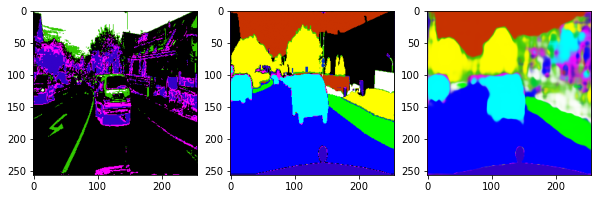

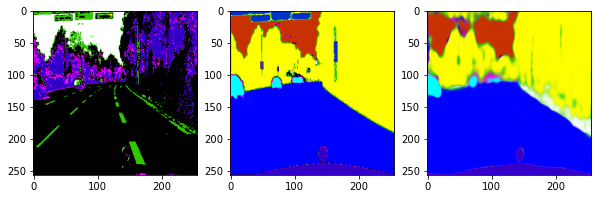

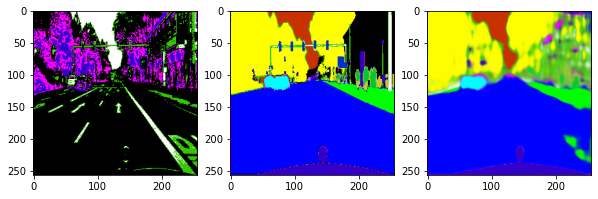

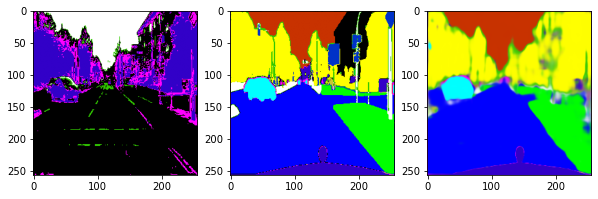

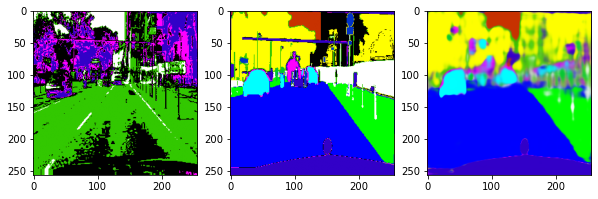

In [102]:
#comparison among converted images
pp2 = model2.predict(x_val[0:5,:,:,:])
ni = 5
for k in range(ni):
    pred = LayersToRGBImage(pp2[k])
    plt.figure(figsize=(10,30))
    plt.subplot(ni,3,1+k*3)
    plt.imshow(LayersToRGBImage(ColorsToClass(x_val[k])))
    plt.subplot(ni,3,2+k*3)
    plt.imshow(LayersToRGBImage(ColorsToClass(y_val[k])))
    plt.subplot(ni,3,3+k*3)
    plt.imshow(pred)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


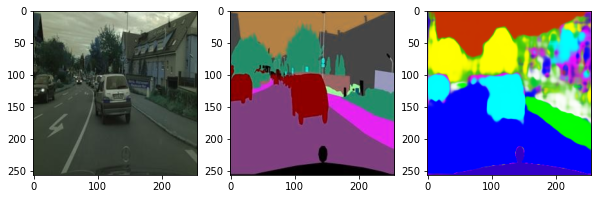

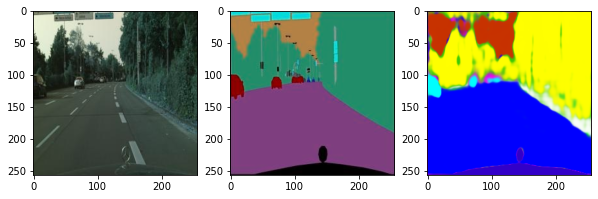

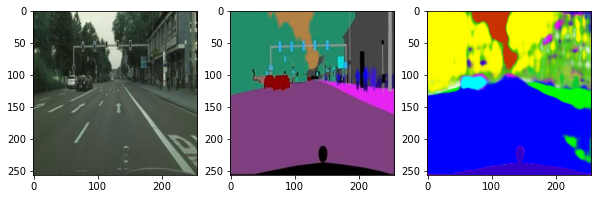

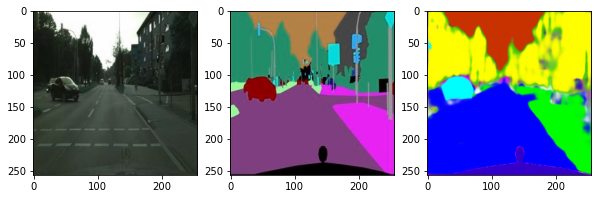

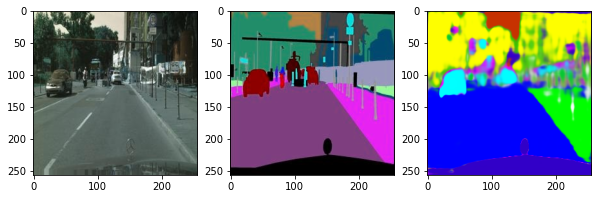

In [104]:
#comparison with original images
for k in range(ni):
    pred = LayersToRGBImage(pp2[k])
    plt.figure(figsize=(10,30))
    plt.subplot(ni,3,1+k*3)
    plt.imshow(x_val[k])
    plt.subplot(ni,3,2+k*3)
    plt.imshow(y_val[k])
    plt.subplot(ni,3,3+k*3)
    plt.imshow(pred)

In [94]:
#To calculate the IoU score, the original validation images are transferred into (256,256,13), and then transfer back
#to (256,256,3)
scores2 = []
a2 = []
b2 = []
pp2 = model.predict(x_val)
for i in range(len(pp2)):
    a2.append(LayersToRGBImage(pp2[i]))
    b2.append(LayersToRGBImage(ColorsToClass(y_val[i])))
    intersection = np.logical_and(b2[i], a2[i])
    union = np.logical_or(b2[i], a2[i])
    iou_score = np.sum(intersection) / np.sum(union)
    scores2.append(iou_score)

In [95]:
#iou score for processed data
#lower than expected
sum(scores2)/len(scores2)

0.4275552029592105

In [96]:
#Manhattan score
norms2=[]
normalized2 = []
for i in range(len(a2)):
    diff2 = b2[i] - a2[i]
    m_norm2 = np.sum(abs(diff2))  
    norms.append(m_norm2)
    normalized.append(m_norm2/(256*256))

In [97]:
sum(normalized)/len(normalized)

0.9519627357240967